One of the great advantages of using simulation is that you can test the
assertions your teachers make.

For example, in the [permutation and t-test page]({{ site.baseurl
}}/chapters/05/permutation_and_t_test), we asserted that the t-test is not
valid when the underlying distribution of the numbers is not close to the
[normal distribution](https://en.wikipedia.org/wiki/Normal_distribution).

We can investigate this claim by simulating numbers from the null (ideal)
world, and seeing what results we get from the t-test.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

The particular variant of the t-test that we were looking at in the page above
was the *independent sample* t test for groups with similar variance.  Similar
variance means that the distribution of the values in the first group is
roughly equal to the distribution in the second group.

For example, soon we will be testing again for a mean difference between the
numbers of mosquitoes attracted to each of the 25 volunteers who drank beer,
and the equivalent numbers for each of the 18 volunteers who drank water.

See [the data
page](https://github.com/matthew-brett/datasets/tree/master/mosquito_beer) for
more details on the dataset, and [the data license page]({{ site.baseurl
}}/data/license).

For an equal variance test, we assume that the spread of the beer values is
roughly equal to the spread of the water values, as measured by the *standard
deviation*, or, equivalently, the *variance*.  Remember the variance is the
squared standard deviation.

We can pull together the code in [permtuation and t-test page]({{ site.baseurl
}}/chapters/05/permutation_and_t_test) to implement our own t-test.

In [2]:
# Import the Scipy statistics routines.
import scipy.stats as sps

In [3]:
def t_test(group1, group2):
    """ Independent sample t value and one-tail upper-tail p value.
    """
    g1_mean = np.mean(group1)
    g2_mean = np.mean(group2)
    omd = g1_mean - g2_mean  # The observed mean difference.
    errors = np.append(group1 - g1_mean, group2 - g2_mean)
    g1_n = len(group1)  # Number of observations in group1
    g2_n = len(group2)  # Number of observations in group2
    df = g1_n + g2_n - 2  # The "degrees of freedom".
    estimated_sd = np.sqrt(np.sum(errors ** 2) / df)
    t_stat = omd / (estimated_sd * np.sqrt(1 / g1_n + 1 / g2_n))
    upper_tail_p_value = 1 - sps.t.cdf(t_stat, df)
    return [t_stat, upper_tail_p_value]

The only new thing in the implementation above is the second-to-last line,
where we are using a routine in Scipy to calculate the probability value from
the t statistic; the details of this are not important for our purpose.

First we go back to the logic of this p value, which is very similar to the
logic for permutation test p values:

* Notice that the function calculates `omd = np.mean(group1) -
  np.mean(group2)`. Call `omd` the *observed mean difference*.
* Assume that we are in the null (ideal) world where the numbers from `group1`
  and the numbers from `group2` have been drawn at random from the *same*
  distribution.
* The p value is the probability, in this null world, of seeing a mean
  difference that is equal to or greater than the observed mean difference
  `omd`.

You can also think of a p value as an *index of surprise*.  The p value tells
you how often you would expect to see an observed mean different this large, or
larger, in the null (ideal) world.  If the p value is small, then the observed
mean difference is surprising.  For example, if the p value is 0.05, it means
that such difference only occurs 5% of the time by chance in the null world, or
1 in 20 times.  You could say it was surprising at a 5% level.  Similarly a p
value of 0.01 means the result would only occur 1% of the time in the null world, and it is surprising at a 1% level.

Here we recreate the mosquito, beer, water data from the [permutation and
t-test page]({{ site.baseurl }}/chapters/05/permutation_and_t_test):

In [4]:
beer_activated = np.array([14, 33, 27, 11, 12, 27, 26,
                           25, 27, 27, 22, 36, 37,  3,
                           23,  7, 25, 17, 36, 31, 30,
                           22, 20, 29, 23])
water_activated = np.array([33, 23, 23, 13, 24,  8,  4,
                            21, 24, 21, 26, 27, 22, 21,
                            25, 20,  7, 3])

We run our t-test over these data to get the same result you saw in the
[permtuation and t-test page]({{ site.baseurl
}}/chapters/05/permutation_and_t_test).

In [5]:
t, p = t_test(beer_activated, water_activated)
print('t statistic:', t)
print('Upper-tail p value:', p)

t statistic: 1.640250605001883
Upper-tail p value: 0.054302080886695414


This means that the observed difference in means:

In [6]:
# Observed mean difference
np.mean(beer_activated) - np.mean(water_activated)

4.433333333333334

would only occur about 5% of the time in a null (ideal) world, where the beer
and water values come from the same distribution.  The observed result is
surprising at around the 5% level.

We check this is the same result we get from using the standard Scipy function:

In [7]:
result = sps.ttest_ind(beer_activated, water_activated)
print('Scipy t statistic:', result.statistic)
print('Scipy upper-tail p value:', result.pvalue / 2)

Scipy t statistic: 1.6402506050018828
Scipy upper-tail p value: 0.054302080886695414


How would we check the assertion that the t-test is valid for normal
distributions?

If it is valid, then consider the situation where we do in fact draw two
samples from *the same* normal distribution, and then ask the t test for a p
value.  If the p value is 5%, it means that such a result should only occur by chance, in the null world, 5% of the time.

So, we can repeat this procedure, drawing numbers that do in fact come from the null world, and check that the t-test only tells us that the result is surprising at the 5% level --- about 5% of the time.

In [8]:
n_iters = 1000
p_values = np.zeros(n_iters)  # Store the p values
for i in np.arange(n_iters):
    # Make 40 numbers from a normal distribution with mean 10, sd 2.
    # These are our numbers from the null world.
    randoms = np.random.normal(10, 2, size=40)
    # Split into two groups of size 20, and do a t-test.
    t, p = t_test(randoms[:20], randoms[20:])
    # Store the p value from the t-test.
    p_values[i] = p
# Show the first 5 p values.
p_values[:5]

array([0.26133841, 0.14503826, 0.5475188 , 0.54285313, 0.90394008])

If the t-test calculation is correct, then we should only see a p value of 0.05
or smaller about 5% of the time.

In [9]:
# Proportion of times the t-test said: surprising at 5% level.
np.count_nonzero(p_values <= 0.05) / n_iters

0.046

Here the t-test is doing a good job --- it labels the result as surprising, at
the 5% level, about 5% of the time.

Now we ask - does it matter if the group sizes are unequal.  Here we do the same calculation, but split the numbers from the null world into one group of 3 and another of 37:

In [10]:
# t-test working on unequal group sizes.
p_values = np.zeros(n_iters)  # Store the p values
for i in np.arange(n_iters):
    # Make 40 numbers from a normal distribution with mean 10, sd 2.
    randoms = np.random.normal(10, 2, size=40)
    # Split into two groups of size 3 and 37, and do a t-test.
    t, p = t_test(randoms[:3], randoms[3:])
    # Store the p value from the t-test.
    p_values[i] = p
# Show the first 5 p values.
p_values[:5]

array([0.21835158, 0.86700815, 0.05440896, 0.55910349, 0.92557139])

How good a job is it doing now, with unequal group sizes?

In [11]:
# Proportion of times the t-test said: surprising at 5% level.
# This time wih unequal group sizes.
np.count_nonzero(p_values <= 0.05) / n_iters

0.046

The proportion is still around 5%, close to what it should be.

What happens if we use a distribution other than the normal distribution.

Here we use some random numbers from a [Chi-squared
distribution](https://en.wikipedia.org/wiki/Chi-squared_distribution).  The distribution looks like this, with a $k$ value of 2 (see the Wikipedia page):

Text(0.5, 1.0, '1000 random samples from chi-squared distribution, k=2')

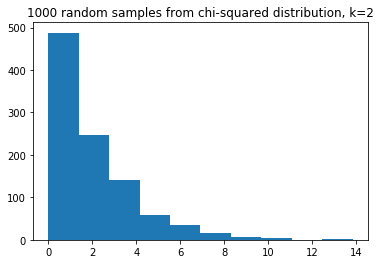

In [12]:
some_chi2_numbers = np.random.chisquare(2, size=1000)
plt.hist(some_chi2_numbers)
plt.title('1000 random samples from chi-squared distribution, k=2')

Now we use this highly not-normal distribution to provide numbers to our t-test:

In [13]:
# t-test working on unequal group sizes and not-normal distribution.
p_values = np.zeros(n_iters)  # Store the p values
for i in np.arange(n_iters):
    # Make 40 numbers from a chi-squared distribution with k=2
    randoms = np.random.chisquare(2, size=40)
    # Split into two groups of size 3 and 37, and do a t-test.
    t, p = t_test(randoms[:3], randoms[3:])
    # Store the p value from the t-test.
    p_values[i] = p
# Show the first 5 p values.
p_values[:5]

array([0.66228688, 0.49605539, 0.23186874, 0.49844466, 0.88475855])

Now the t-test starts to be less accurate - labeling too many random differences as being surprising at the 5% level:

In [14]:
# Proportion of times the t-test said: surprising at 5% level.
# This time wih unequal group sizes.
np.count_nonzero(p_values <= 0.05) / n_iters

0.074

Does a permutation test do a better job in this situation?

We can test!

Here is a function that does a permutation test:

In [15]:
def permutation(group1, group2, niters=10000):
    omd = np.mean(group1) - np.mean(group2)
    g1_n = len(group1)
    fake_mds = np.zeros(niters)
    pooled = np.append(group1, group2)
    for i in np.arange(niters):
        np.random.shuffle(pooled)
        fake_mds[i] = np.mean(pooled[:g1_n]) - np.mean(pooled[g1_n:])
    return np.count_nonzero(fake_mds >= omd) / niters

Test this on the mosquito data:

In [16]:
permutation(beer_activated, water_activated)

0.0577

This is very similar to the t-statistic p value --- *for these data* that have fairly equal group size, and a distribution not far from normal:

In [17]:
t_test(beer_activated, water_activated)

[1.640250605001883, 0.054302080886695414]

Now let's check if the permutation test also trips up on the unequal group
sizes and not-normal distribution.

The code below will take a few tens of seconds to run, because you are running many
loops in the `permutation` function, each time you go through the main
loop.

In [18]:
# Permutation working on unequal group sizes and not-normal distribution.
p_values = np.zeros(n_iters)  # Store the p values
for i in np.arange(n_iters):
    # Make 40 numbers from a chi-squared distribution with k=2
    randoms = np.random.chisquare(2, size=40)
    # Split into two groups of size 3 and 37, and do a t-test.
    # Use relatively few iterations to save computation time.
    p = permutation(randoms[:3], randoms[3:], niters=1000)
    # Store the p value from the permutation test.
    p_values[i] = p
# Show the first 5 p values.
p_values[:5]

array([0.894, 0.174, 0.783, 0.261, 0.841])

How does the permutation test do?

In [19]:
# Proportion of times the permutation test said: surprising at 5% level.
# With unequal group sizes, not-normal distribution.
np.count_nonzero(p_values <= 0.05) / n_iters

0.063

It is more accurate.   In general the permutation method is more accurate
for data from not-normal distributions, as well being accurate for normal
distributions.